## Import Packages

In [6]:
import cv2
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import time
import cv2
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.neural_network import MLPClassifier
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

## Load Images

In [7]:
# Load images first
numImages = len(glob.glob('./images/*jpg'))
images = [None for i in xrange(numImages)]
for fileName in glob.glob('./images/*jpg'):
    fileNum = int(fileName[9:][:-4])
    images[fileNum-1] = np.array(cv2.imread(fileName, 0))
images = np.array(images)

# Load csv data next
train_data = pd.read_csv('data/train.csv').drop(['species'], axis=1).values
train_labels = pd.read_csv('data/train.csv')['species'].values
labels=train_labels.tolist()
train_images = [images[int(data[0]-1)] for data in train_data]
train_ids = [data[0] for data in train_data]
train_data = np.delete(train_data, 0, 1)


test_data = pd.read_csv('data/test.csv').values
test_images = [images[int(data[0]-1)] for data in test_data]
test_ids = [data[0] for data in test_data]
test_data = np.delete(test_data, 0, 1)

del images

## Define Image Normalization and Batching

In [8]:
#CNN train data
def img_norm(img):
    t= 2 * (np.float32(img) / 255 - 0.5) # normalize img pixels to [-1, 1]
    return t
def minibatchData(data,labels_encoded,img_size,channel_num=1,batch_num=30):
    images=[]
    for img in data:
        images.append(img_norm(cv2.resize(img,img_size)))
    
    channel_num=1
    if batch_num > 1:
        batch_data = []
        batch_labels = []
        
        print(len(images))
        print(batch_num)
        
        for i in range(int(len(images) / batch_num)):
            minibatch_d = images[i*batch_num: (i+1)*batch_num]
            minibatch_d = np.reshape(minibatch_d, (batch_num, channel_num,img_size[0],img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))
            if labels_encoded is not None:
                minibatch_l = labels_encoded[i*batch_num: (i+1)*batch_num]
                batch_labels.append(torch.LongTensor(minibatch_l))
            else:
                minibatch_l = np.zeros(batch_num)
                batch_labels.append(torch.LongTensor(minibatch_l))
        #data, labels = batch_data, batch_labels 
        
    return zip(batch_data, batch_labels)

## Preprocess the Labels

In [9]:
le= preprocessing.LabelEncoder()
#encode train labels
le.fit(train_labels)
train_labels_encoded=le.transform(train_labels)

990
30
594
30


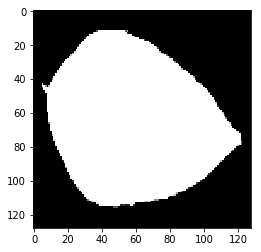

In [10]:
img_size=(128,128)
cnn_train_data = list(minibatchData(train_images,train_labels_encoded,img_size))
#plt.imshow(cnn_train_data[0][0][3][0])
cnn_test_data = list(minibatchData(test_images,None,img_size))
#print cnn_train_data.size
plt.imshow(cnn_test_data[0][0][10][0],'gray')

## Build, Test, and Train a Convolutional Network In PyTorch

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.dropout=nn.Dropout(0.5)
        #self.conv3 = nn.Conv2d(32, 64, 4)
        self.fc1 = nn.Linear(32*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 99)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print x.shape
        x = self.pool(F.relu(self.conv2(x)))
        #print x.shape
        x=self.dropout(x)
        x = x.view(-1, 32*6*6)
        #print x.shape
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print x.shape
        return x


In [10]:
net =Net()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [11]:

start_time = time.time()
for epoch in range(200):  # loop over the dataset multiple times

    running_loss = 0.0
    for i,data in enumerate(cnn_train_data,0):
        # get the inputs
        inputs, labels = data
        #print inputs
        #print inputs.shape
        optimizer_ft.zero_grad()
       # print inputs.type('torch.DoubleTensor')
        #inputs=inputs.type('torch.DoubleTensor')
        # forward + backward + optimize
        outputs = net(inputs)
        #print outputs.shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_ft.step()
        
        running_loss += loss.item()
        if i % 30 == 29:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 990))   
            running_loss = 0.0
end_time = time.time()

print('Finished Training in:',end_time-start_time)



[1,    30] loss: 0.139
[2,    30] loss: 0.139
[3,    30] loss: 0.139
[4,    30] loss: 0.139
[5,    30] loss: 0.139
[6,    30] loss: 0.139
[7,    30] loss: 0.139
[8,    30] loss: 0.139
[9,    30] loss: 0.139
[10,    30] loss: 0.139
[11,    30] loss: 0.139
[12,    30] loss: 0.139
[13,    30] loss: 0.139
[14,    30] loss: 0.139
[15,    30] loss: 0.139
[16,    30] loss: 0.139
[17,    30] loss: 0.139
[18,    30] loss: 0.139
[19,    30] loss: 0.139
[20,    30] loss: 0.139
[21,    30] loss: 0.139
[22,    30] loss: 0.139
[23,    30] loss: 0.138
[24,    30] loss: 0.138
[25,    30] loss: 0.138
[26,    30] loss: 0.138
[27,    30] loss: 0.138
[28,    30] loss: 0.138
[29,    30] loss: 0.137
[30,    30] loss: 0.137
[31,    30] loss: 0.136
[32,    30] loss: 0.135
[33,    30] loss: 0.134
[34,    30] loss: 0.133
[35,    30] loss: 0.131
[36,    30] loss: 0.127
[37,    30] loss: 0.123
[38,    30] loss: 0.118
[39,    30] loss: 0.112
[40,    30] loss: 0.107
[41,    30] loss: 0.102
[42,    30] loss: 0.097
[

In [18]:
probs_cnn_train=np.empty([0,99])
probs_cnn_test=np.empty([0,99])
sm = torch.nn.Softmax()
for data in cnn_train_data:
    images,labels=data
    probs_cnn_train=np.append(probs_cnn_train,sm(net(images)).data.numpy(),axis=0)
print probs_cnn_train.shape
    
for data in cnn_test_data:
    images, labels = data
    probs_cnn_test=np.append(probs_cnn_test,sm(net(images)).data.numpy(),axis=0)
    #outputs=np.append(outputs,net(images).data.numpy(),axis=0)
    #print probs
    

print probs_cnn_test.shape

#sm = torch.nn.Softmax()
#probabilities = sm(output) 
#print(probabilities)

/Users/anishsaha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


(990, 99)


/Users/anishsaha/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


(594, 99)


## Extract Partitioned Data

In [19]:
#separate the 3 histograms
train_margin_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'margin1':'margin64']).values
train_shape_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'shape1':'shape64']).values
train_texture_data=((pd.read_csv('data/train.csv').drop(['species'], axis=1)).loc[:,'texture1':'texture64']).values

test_margin_data=((pd.read_csv('data/test.csv')).loc[:,'margin1':'margin64']).values
test_shape_data=((pd.read_csv('data/test.csv')).loc[:,'shape1':'shape64']).values
test_texture_data=((pd.read_csv('data/test.csv')).loc[:,'texture1':'texture64']).values

#print train_margin_data.head()
#print train_shape_data.head()
#print train_texture_data.head()

In [20]:
def get_descriptor(images, dense=False):
    sift = cv2.xfeatures2d.SIFT_create()
    des_per_Img = np.array([sift.detectAndCompute(img,None)[1] for img in images])
    return des_per_Img
        
def get_clusters(descriptors, vocabSize):
    des_list = np.concatenate(descriptors)

    kmeans = MiniBatchKMeans(vocabSize, batch_size=100)
    kmeans.fit(np.array(des_list))
    
    return kmeans

def get_vocabulary(descriptors, clusters, vocabSize):
    return np.array([normalize(np.histogram(clusters.predict(dscrs), bins=range(vocabSize))[0].reshape(1,-1)).ravel() for dscrs in descriptors])
        

In [21]:
des_start_time =time.time()
des_list_train = get_descriptor(train_images)
des_list_test = get_descriptor(test_images)
des_end_time =time.time()
print "Descriptors computed in {:2f} seconds".format(des_end_time-des_start_time)

Descriptors computed in 129.263396 seconds


In [22]:
clustering_start_time=time.time()
clusters = get_clusters(des_list_train,150)
clustering_end_time=time.time()
print "Clustering completed in {:2f} seconds".format(clustering_end_time-clustering_start_time)

Clustering completed in 2.878999 seconds


In [23]:
vocab_train = get_vocabulary(des_list_train,clusters,150)
vocab_test = get_vocabulary(des_list_test,clusters,150)

print vocab_train.shape

(990, 149)


## Train Weak Learners

In [24]:
mlp_train_margin = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(80,))
mlp_train_margin.fit(train_margin_data, train_labels_encoded)
mlp_train_margin_pred = mlp_train_margin.predict_proba(train_margin_data)

mlp_train_texture = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(80,))
mlp_train_texture.fit(train_texture_data, train_labels_encoded)
mlp_train_texture_pred = mlp_train_texture.predict_proba(train_texture_data)

mlp_train_shape = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(80,))
mlp_train_shape.fit(train_shape_data, train_labels_encoded)
mlp_train_shape_pred = mlp_train_shape.predict_proba(train_shape_data)

mlp_train_sift_bof = MLPClassifier(learning_rate='constant', max_iter=5000,hidden_layer_sizes=(80,))
mlp_train_sift_bof.fit(vocab_train, train_labels_encoded)
mlp_train_sift_bof_pred = mlp_train_sift_bof.predict_proba(vocab_train)

second_level_input = np.array(np.append(mlp_train_margin_pred,mlp_train_texture_pred,axis=1))
second_level_input = np.array(np.append(second_level_input,mlp_train_shape_pred,axis=1))
second_level_input = np.array(np.append(second_level_input,mlp_train_sift_bof_pred,axis=1))
second_level_input = np.array(np.append(second_level_input,probs_cnn_train,axis=1))
print second_level_input.shape

(990, 495)


## Fit the basic boosted network

In [32]:
mlc_model = MLPClassifier(learning_rate='constant', max_iter=8000,hidden_layer_sizes=(520,))
mlc_model.fit(second_level_input, train_labels_encoded)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(520,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=8000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [33]:
out_file = generateDeepSubmission(test_ids,test_margin_data,test_texture_data,test_shape_data,vocab_test,mlp_train_margin, mlp_train_texture,mlp_train_shape,mlp_train_sift_bof,probs_cnn_test,mlc_model,99)



(594, 495)


## Prepare and Export the Output File

In [26]:
def generateDeepSubmission(ids,test_l1,test_l2,test_l3,test_l4
                           ,model_b1,model_b2,model_b3,model_b4,cnn_test_data,model_top,num_classes):
    num_test = len(test_l1)
    block1_pred = model_b1.predict_proba(test_l1)
    block2_pred = model_b2.predict_proba(test_l2)
    block3_pred = model_b3.predict_proba(test_l3)
    block4_pred = model_b4.predict_proba(test_l4)
    final_input = np.array(np.append(block1_pred,block2_pred,axis=1))
    final_input = np.array(np.append(final_input,block3_pred,axis=1))
    final_input = np.array(np.append(final_input,block4_pred,axis=1))
    final_input = np.array(np.append(final_input,cnn_test_data,axis=1))
    print final_input.shape
    final_pred = model_top.predict(final_input)
    final_confidence =  model_top.predict_proba(final_input)
    final_confidence = np.append(np.array(ids).reshape(-1,1),final_confidence,axis=1)
    
    return final_confidence
    #for i in xrange()
    #return final_pred

In [1]:
# #predict using KNN
# preds_knn=knn_model.predict(test_data)
# #predict using SVM
# preds_svm=svm_model.decision_function(test_data)
# print np.array(preds_svm).shape

def generateSubmission(ids, test, model, num_classes):
    num_test = len(test)
    predictions = model.predict(test)
    confidence = model.predict_proba(test)
    output = np.zeros((num_test, num_classes+1))
    
    for i in xrange(num_test):
        p = predictions[i]
        c = confidence[i][p]
        #prob = c
        prob = min(max(10e-15, c), 1-10e-15)
        logLoss = np.log(prob)
        output[i][p+1] = -logLoss / num_test
        output[i][0] = ids[i]
    return output

In [34]:
# out_file = generateSubmission(test_ids, test_data,svm_model,99)
headerRow=np.array(['id'] + le.inverse_transform(range(99)).tolist())
df = pd.DataFrame(data=out_file, columns = headerRow)
df['id'] = df['id'].astype(np.int)
df=df.set_index('id')
#print df.head()
# np.set_printoptions(threshold=np.inf)
# print out_file
df.to_csv('output/26_11_18_003(cnn).csv')

/Users/anishsaha/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
